In [26]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, roc_curve
from sklearn.linear_model import LogisticRegression as LR
from sklearn import metrics 
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import LeaveOneOut

In [27]:
data = pd.read_csv("../Data/10-14_features_filenames.csv")
data = data.dropna()

In [28]:
data.head()

,canny_mean,canny_var,lapl_mean,lapl_var,image_mean,image_var,class,file_name
0,0.471296,119.958439,-0.000956,32.144038,169.758423,1053.143289,dust,ESP_011492_1260_RED.NOMAP.browse-Block-2.jpg
1,0.085602,21.821133,0.000091,26.659139,163.944968,387.122159,dust,ESP_011492_1260_RED.NOMAP.browse-Block-3.jpg
2,0.063896,16.289339,0.000134,27.413486,193.381032,483.033577,dust,ESP_011492_1260_RED.NOMAP.browse-Block-7.jpg
3,0.028911,7.371473,0.000451,26.858970,146.070319,749.250395,dust,ESP_011492_1260_RED.NOMAP.browse-Block-8.jpg
4,0.000000,0.000000,-0.002283,3.692830,196.721007,1060.959619,dust,ESP_012326_2125_RED.NOMAP.browse-Block-1.jpg


In [29]:
data["class"].value_counts()

no_dust    1149
dust        396
Name: class, dtype: int64

In [30]:
# Use a simple regex to get unique HiRise ID location ID numbers.
# So that we can group images of the same region together.

# Separate out the digits which identify the photographed region:
# oooooo_tttt, i.e.
# <orbit_number>_<target_code>
from sklearn.model_selection import GroupKFold
import re
def target_regex(filename):
    region_string = re.search("[0-9]{6}_[0-9]{4}", filename)
    return int(region_string.group())

data["target_location"] = data["file_name"].apply(target_regex)

In [31]:
# Define image groups, input variables, output variables
groups = np.array(data["target_location"])
x = np.array(data.iloc[:,0:5])
y = np.array(data["class"])
y = [1 if name == "dust" else 0 for name in y]
print("Number of images: " + str(len(np.unique(groups))))
print("Unique image groups: " + str(len(np.unique(groups))))

Number of images: 402
Unique image groups: 402


In [33]:
# Show the 34% class imbalance
np.sum(data["class"] == "dust") / np.sum(data["class"] == "no_dust")

0.34464751958224543

In [34]:
# Use 10 folds,
# splitting the dataset into  CV sections
# with roughly 10 samples.
# Get accuracy, recall, precision.
# Sometimes no positive predictions are made,
# resulting in undefined precision, recall, and auc
def cv_scores(model, x, y, label, cv, groups=None):
    model_cv_results = cross_validate(model, x, y, cv=cv, groups=groups, scoring=["accuracy", "precision", "recall", "roc_auc"])
    model_cv_acc_mean = np.mean(model_cv_results["test_accuracy"])
    model_cv_precision_mean = np.mean(model_cv_results["test_precision"])
    model_cv_recall_mean = np.mean(model_cv_results["test_recall"])
    model_cv_auc_mean = np.mean(model_cv_results["test_roc_auc"])
    print(label)
    print("Accuracy: " + str(model_cv_acc_mean))
    print("Precision: " + str(model_cv_precision_mean))
    print("Recall: " + str(model_cv_recall_mean))
    print("AUC: " + str(model_cv_auc_mean))
    

In [35]:
# Define cv splitting objects for use in cv_scores function
group_kfold = GroupKFold(n_splits=10)
sfold = StratifiedKFold(10, shuffle=True)

In [36]:
# Logistic Regression - Without GroupKFold
lr_model = LR()
cv_scores(lr_model, x, y, "Logistic Regression With No Groups", sfold)

Logistic Regression With No Groups
Accuracy: 0.8149099287808965
Precision: 0.6262889867612489
Recall: 0.7069230769230769
AUC: 0.8800066156193157


In [39]:
# Logistic Regression - With GroupKFold
cv_scores(lr_model, x, y, "Logistic Regression With Groups", group_kfold, groups=groups)

Logistic Regression With Groups
Accuracy: 0.81865521575199
Precision: 0.6230617550991059
Recall: 0.7488302170995578
AUC: 0.8802468816590373


In [40]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 500)
cv_scores(rf, x, y, "Random Forest With No Groups", sfold)

Random Forest With No Groups
Accuracy: 0.8705613741097611
Precision: 0.7674831828863184
Recall: 0.7172435897435898
AUC: 0.927284676993487


In [41]:
cv_scores(rf, x, y, "Random Forest With Groups", group_kfold, groups)

Random Forest With Groups
Accuracy: 0.8354629241726016
Precision: 0.6923303622378445
Recall: 0.6364764842770698
AUC: 0.8980401673493426


In [42]:
#Support Vector Classifier
from sklearn.svm import SVC
svc = SVC(random_state = 45, probability = True)
cv_scores(svc, x, y, "Support Vector Classifier With No Groups", sfold)

Support Vector Classifier With No Groups
Accuracy: 0.7727775450356096
Precision: 0.5361006206244185
Recall: 0.934551282051282
AUC: 0.889430572669131


In [43]:
cv_scores(svc, x, y, "Support Vector Classifier With Groups", group_kfold, groups)

C:\Users\dpale\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Support Vector Classifier With Groups
Accuracy: 0.7506577293674068
Precision: 0.4511363447717926
Recall: 0.8538712367765926
AUC: 0.8941751828528753


In [44]:
def tts_predict(model, x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y)
    model.fit(x_train, y_train)
    y_prob = model.predict_proba(x_test)[:,1]
    y_predict = model.predict(x_test)
    return y_test, y_prob, y_predict

In [24]:
# Take 1000 train/test splits, 
# calculate means of precisions and accuracies
# from predictions.
precision_scores = []
recall_scores = []
auc_scores = []
acc_scores = []

for i in range(1000):
    y_test, y_prob, y_predict = tts_predict(rf, x, y)
    precision_scores.append(precision_score(y_test, y_predict))
    recall_scores.append(recall_score(y_test, y_predict))
    auc_scores.append(roc_auc_score(y_test, y_prob))
    acc_scores.append(accuracy_score(y_test, y_predict))
    
precision_mean = np.mean(precision_scores)
recall_mean = np.mean(recall_scores)
auc_mean = np.mean(auc_scores)
acc_mean = np.mean(acc_scores)

print("Random Forest Metrics - 1000 Train/Test Splits")
print("Accuracy Mean: " + str(acc_mean))
print("Precision Mean: " + str(precision_mean))
print("Recall Mean: " + str(recall_mean))
print("AUC Mean: " + str(auc_mean))

KeyboardInterrupt: 

In [ ]:
precision_mean = np.mean(precision_scores)
recall_mean = np.mean(recall_scores)
auc_mean = np.mean(auc_scores)
acc_mean = np.mean(acc_scores)

print("Linear Regression Metrics - 1000 Train/Test Splits")
print("Accuracy Mean: " + str(acc_mean))
print("Precision Mean: " + str(precision_mean))
print("Recall Mean: " + str(recall_mean))
print("AUC Mean: " + str(auc_mean))

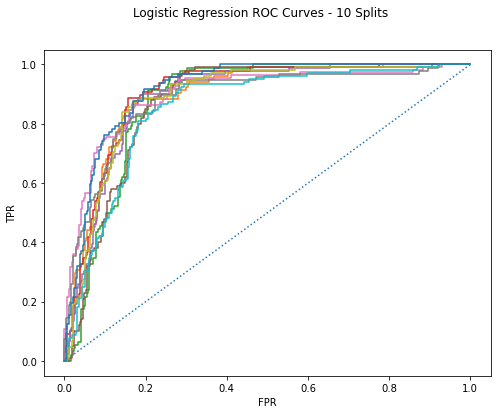

In [47]:
from sklearn.metrics import plot_roc_curve
fig = plt.gcf()
fig.set_size_inches(8,6)
fig.suptitle("Logistic Regression ROC Curves - 10 Splits")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot([0, 1], [0, 1], linestyle="dotted")
for i in range(10):
    y_test, y_prob, y_predict = tts_predict(lr_model, x, y)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr)

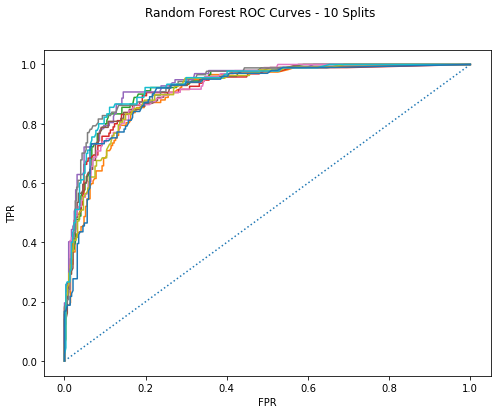

In [49]:
fig = plt.gcf()
fig.set_size_inches(8,6)
fig.suptitle("Random Forest ROC Curves - 10 Splits")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot([0, 1], [0, 1], linestyle="dotted")
for i in range(10):
    y_test, y_prob, y_predict = tts_predict(rf, x, y)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr)

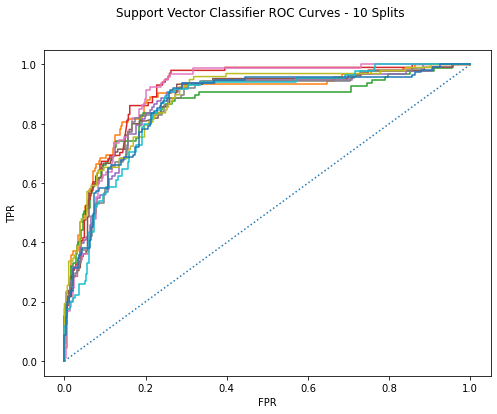

In [50]:
fig = plt.gcf()
fig.set_size_inches(8,6)
fig.suptitle("Support Vector Classifier ROC Curves - 10 Splits")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot([0, 1], [0, 1], linestyle="dotted")
for i in range(10):
    y_test, y_prob, y_predict = tts_predict(svc, x, y)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr)